# NSE vs. Direct Integration

In [1]:
import pynucastro as pyna

To further demonstrate the validity of the NSE equation, 
we will compare the equilibrium mass fractions computed via direct integration and the mass fractions obtained from NSE equations.

We will create the {py:obj}`PythonNetwork <pynucastro.networks.python_network.PythonNetwork>` needed for direct integration using the same set of nuclei as our previous example.

First we recreate our library, but we make sure that we use reverse rates calculated via detailed balance.
In pynucastro, this is the {py:obj}`DerivedRate <pynucastro.rates.derived_rate.DerivedRate>`.

In [2]:
rl = pyna.ReacLibLibrary()

all_nuclei = ["p", "he4",
              "c12", "n13",
              "o16", "f17",
              "ne20", "na23",
              "mg24", "al27", "si28",
              "p31", "s32", "cl35",
              "ar36", "k39", "ca40",
              "sc43", "ti44", "v47",
              "cr48", "mn51",
              "fe52","co55","ni56"]

lib = rl.linking_nuclei(all_nuclei)

Here we search through the existing ReacLib reverse rates and remove them. So that `Library` only contains forward rates.  We use the {py:meth}`backward <pynucastro.rates.library.Library.backward>` method for this.

In [3]:
reverse_rates = lib.backward().get_rates()
for r in reverse_rates:
    lib.remove_rate(r)

Now create the corresponding `DerivedRate` using the forward rate and add them to `Library`. 

In [4]:
for r in lib.get_rates():
    d = pyna.DerivedRate(source_rate=r, use_pf=True)
    lib.add_rate(d)

We can also use {py:obj}`ModifiedRate <pynucastro.rates.modified_rate.ModifiedRate>` where we modify the reactants and/or the products of a reaction rate but still use the original rate. This is compatible with NSE as long as a corresponding `DerivedRate` is added.

```{warning}
Currently `stoichiometry` does NOT work with NSE.
```

In [5]:
other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]
for r, mp in other_rates:
    _r = rl.get_rate_by_name(r)
    forward_rate = pyna.ModifiedRate(_r, new_products=[mp])
    derived_rate = pyna.DerivedRate(source_rate=forward_rate, use_pf=True)
    lib.add_rates([forward_rate, derived_rate])

The {py:obj}`TemperatureTabularRate <pynucastro.rates.temperature_tabular_rate.TemperatureTabularRate>`, in which the strong reaction rate is tabulated, is also compatible with NSE as long as a corresponding `DerivedRate` is added. We will use {py:obj}`IliadisO16pgF17 <pynucastro.rates.alternate_rates.IliadisO16pgF17>`, a subclass of `TemperatureTabularRate` for `O16(p,g)F17` rate, as an example to demonstrate compatibility with NSE.

Let's remove the {py:obj}`ReacLibRate <pynucastro.rates.reaclib_rate.ReacLibRate>` version for `O16(p,g)F17` and its `DerivedRate` and add `IliadisO16pgF17` and its corresponding `DerivedRate`.

In [6]:
rates_to_remove = ["o16(p,g)f17", "f17(g,p)o16"]
for r in rates_to_remove:
    _r = lib.get_rate_by_name(r)
    lib.remove_rate(_r)

iliadis = pyna.rates.alternate_rates.IliadisO16pgF17()
iliadis_derived = pyna.DerivedRate(iliadis, use_pf=True)

lib.add_rate(iliadis)
lib.add_rate(iliadis_derived)

Now create the `PythonNetwork` using the modified `Library` object.

In [7]:
net = pyna.PythonNetwork(libraries=lib)

We can also do some approximations, such as the $(\alpha,p)(p,\gamma)$ approximation. This is fully compatible with NSE.

In [8]:
net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47", "mn51", "co55"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47", "mn51", "co55"])

Finally, we write out python module that contains essential functions needed for integration, such as the `rhs` and `jacobian`.

In [9]:
net.write_network(outfile="network.py")

/home/zhi/Github/pynucastro/pynucastro/rates/derived_rate.py:120: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/home/zhi/Github/pynucastro/pynucastro/rates/derived_rate.py:120: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


```{important}
In order for the integrated equilibrium result to be fully compatible with NSE equations, watch out for a number of things:
1. Make sure that all forward rates in the network has a corresponding `DerivedRate`. Otherwise there is no detailed balance.
2. All species are connected.
3. NSE only guarantees equilibrium of strong reactions. So if there are weak rates in the network, $Y_e$ will evolve in time.
```

## Direct integration

Now we want to integrate.  Since we will compare to NSE, we want to use the same screening that NSE uses--{py:meth}`potekhin_1998 <pynucastro.screening.screen.potekhin_1998>`

In [10]:
from pynucastro.screening import potekhin_1998
import network

and we'll integrate using `solve_ivp` from `scipy.integrate`

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Set up an initial condition and let it evolve until we reach equilibrium.

In [12]:
rho = 1e7
T = 6e9

X0 = np.ones(network.nnuc)
X0 /= np.sum(X0)
Y0 = X0/network.A

ye = network.ye(Y0)

tmax = 1.e-1
sol = solve_ivp(network.rhs, [0, tmax], Y0, method="BDF",
                 dense_output=True, args=(rho, T, potekhin_1998),
                 rtol=3.e-14, atol=3.e-14, jac=network.jacobian)

Let's plot the evolution to see how mass fraction evolve with time. Equilibrium is indicated by flat lines.

In [13]:
nucs = list(map(pyna.Nucleus, network.names))
nuc_labels = [f"${n.pretty}$" for n in nucs]

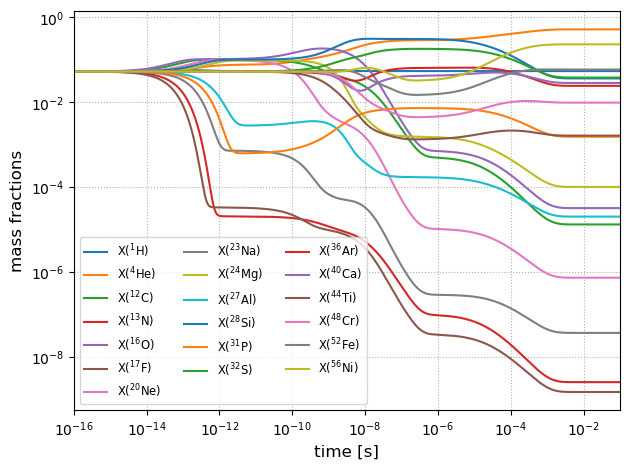

In [14]:
fig, ax = plt.subplots()
for i in range(network.nnuc):
    ax.loglog(sol.t, sol.y[i,:]*network.A[i], label=rf"X(${nucs[i].pretty}$)")

ax.set_xlim(1e-16, tmax)
ax.set_xlabel(f"time [s]", fontsize=12)
ax.set_ylabel(f"mass fractions", fontsize=12)
ax.legend(loc="best", fontsize="small", ncol=3)
ax.grid(ls=":")
fig.tight_layout()

## NSE calculation

We can create an {py:obj}`NSENetwork <pynucastro.networks.nse_network.NSENetwork>` by simply grabbing the rates from our current network and using them to construct the NSE
network

In [15]:
nse = pyna.NSENetwork(rates=net.get_rates())
nse.summary()

Network summary
---------------
  explicitly carried nuclei: 19
  approximated-out nuclei: 6
  inert nuclei (included in carried): 0

  total number of rates: 109

  rates explicitly connecting nuclei: 70
  hidden rates: 39

  reaclib rates: 46
  weak tabular rates: 0
  temperature tabular rates: 1
  approximate rates: 12
  derived rates: 47
  modified rates: 3
  custom rates: 0


Now let's get the directly-computed NSE state

In [16]:
nse_comp = nse.get_comp_nse(rho, T, ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

Finally, we can make some plots to see the direct comparison between the two results.

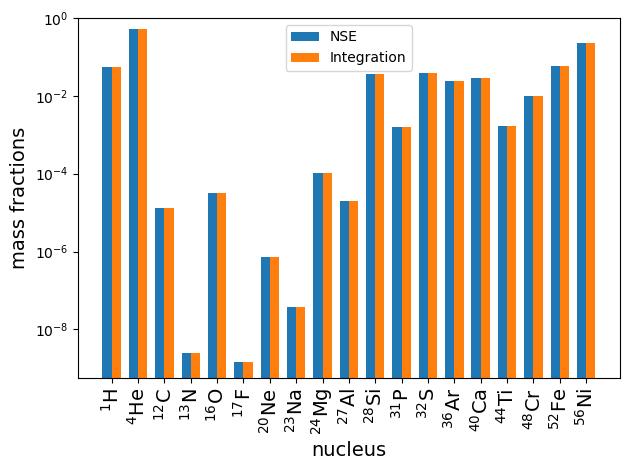

In [17]:
X_net = sol.y[:,-1]*network.A
X_nse = np.array(list(nse_comp.X.values()))

x = np.arange(len(network.names))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2.0, X_nse, width, label = 'NSE')
ax.bar(x + width/2.0, X_net, width, label = 'Integration')
ax.set_xlabel("nucleus", fontsize=14)
ax.set_xticks(x, labels=nuc_labels, rotation=90, fontsize=14)
ax.set_ylabel("mass fractions", fontsize=14)
ax.legend(fontsize=14)
ax.set_yscale("log")
ax.set_ylim(ymax = 1)
ax.legend()
fig.tight_layout()

Now a plot of absolute and relative difference shows that the mass fraction obtained from direct integration matches with NSE equations to machine precision. The differences between the two are largely set by the tolerances of both the NSE solver and the ODE integrator.

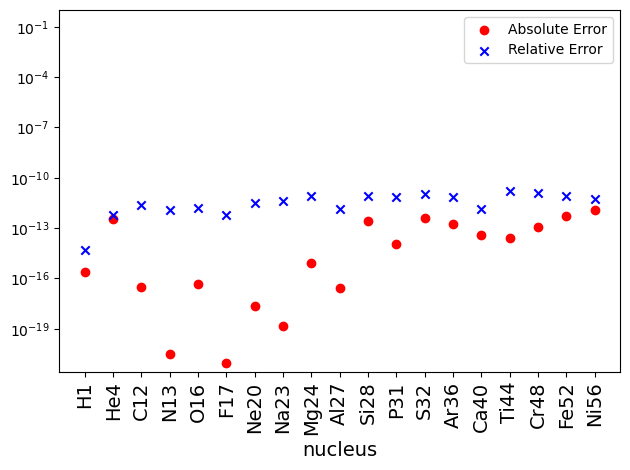

In [18]:
diff = np.abs(X_net - X_nse) 
diff_rel = diff / X_net

fig, ax = plt.subplots()
ax.scatter(x, diff, label='Absolute Error', marker='o', color='r')
ax.scatter(x, diff_rel, label='Relative Error', marker ='x', color='b')
ax.set_xticks(x, labels=nucs, rotation=90, fontsize=14)
ax.set_xlabel("nucleus", fontsize=14)
ax.set_yscale("log")
ax.legend(fontsize=14)
ax.set_ylim(ymax = 1)
ax.legend()
fig.tight_layout()

## Visualizing equilibrium

At equilibrium, the forward and reverse rates linking nuclei should come into balance.  We can visualize this
graphically using the network {py:meth}`plot <pynucastro.networks.rate_collection.RateCollection.plot>` function,
and plotting the difference between the forward and reverse rates (`use_net_rate=True`).  We will also normalize
by the total activity of the rate (forward + reverse) by doing `normalize_net_rate=True`.

First we'll convert the final composition from the integration into a pynucastro {py:obj}`Composition <pynucastro.networks.rate_collection.Composition>`, keeping in mind that the network evolved molar fractions ($Y = X / A$).

In [19]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_array(sol.y[:, -1] * network.A)

/home/zhi/Github/pynucastro/pynucastro/rates/derived_rate.py:120: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/home/zhi/Github/pynucastro/pynucastro/rates/derived_rate.py:120: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


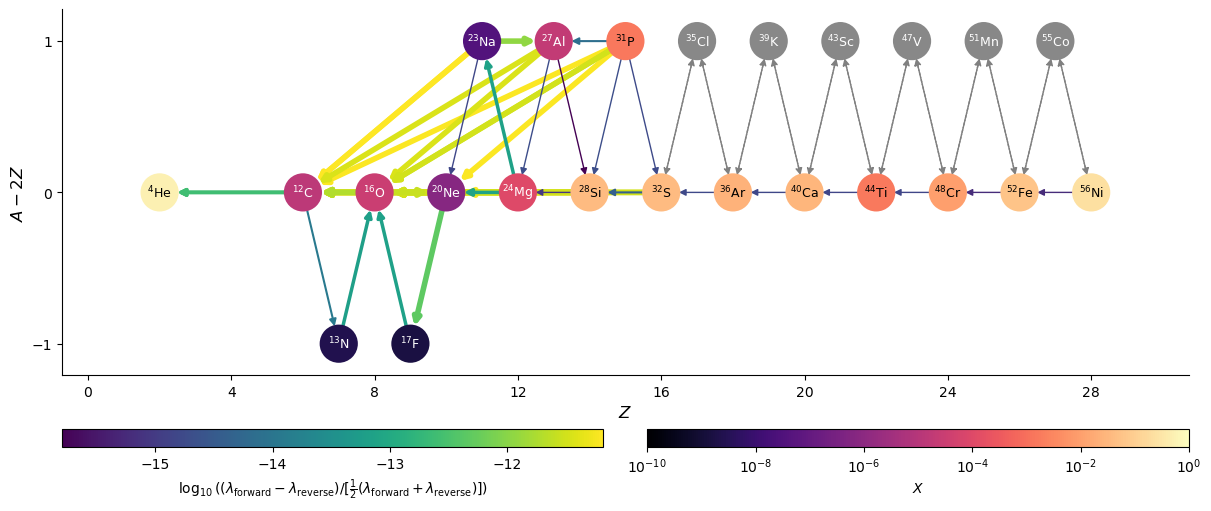

In [20]:
fig = net.plot(rho, T, comp,
               screen_func=potekhin_1998,
               rotated=True, size=(1200, 500),
               node_size=650, node_font_size="9",
               use_net_rate=True, normalize_net_rate=True,
               color_nodes_by_abundance=True,
               hide_xalpha=True)

Here we see that the normalized net rates are all < $10^{-12}$, so we are effectively seeing the integration tolerance, and are very close to machine precision.